# Collaborative filtering on Google Analytics data (operationalized)

This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering. Unlike [wals.ipynb](wals.ipynb), this notebook uses TensorFlow Transform to carry out the preprocessing. This way, these steps are automated:
* Mapping visitorId (a string) to userId (an enumeration)
* Mapping contentId (a string) to itemId (an enumeration)
* Removing already viewed items from the batch prediction output
* Replacing the userId and visitorId in batch prediction output by visitorId and contentId

Apache Beam only works in Python 2 at the moment, so we're going to switch to the Python 2 kernel. In the above menu, click the dropdown arrow and select `python2`. 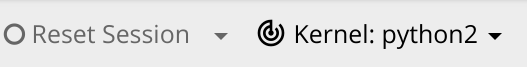

Only [specific combinations](https://github.com/tensorflow/transform#compatible-versions) of TensorFlow, Beam and TensorFlow Transform are supported.  After running the following cell, Reset the notebook.

In [ ]:
%%bash
source activate py2env
pip uninstall -y google-cloud-dataflow
conda install -y pytz==2018.4
pip install apache-beam[gcp] tensorflow_transform==0.8.0

In [ ]:
%bash
pip freeze | grep -e 'flow\|beam'

Now reset notebook's session kernel!

In [ ]:
import os
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [ ]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

In [ ]:
import tensorflow as tf
print tf.__version__

## Create dataset for WALS using TF Transform
<p>
For collaborative filtering, we don't need to know anything about either the users or the content. Essentially, all we need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, we are working with newspaper articles. The company doesn't ask their users to rate the articles. However, we can use the time-spent on the page as a proxy for rating.
<p>
Normally, we would also add a time filter to this ("latest 7 days"), but our dataset is itself limited to a few days.

In [ ]:
query="""
#standardSQL
WITH visitor_page_content AS (

   SELECT  
     fullVisitorID,
     (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
     (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
   FROM `cloud-training-demos.GA360_test.ga_sessions_sample`,   
     UNNEST(hits) AS hits
   WHERE 
     # only include hits on pages
      hits.type = "PAGE"

   GROUP BY   
     fullVisitorId, latestContentId, hits.time
     )

# aggregate web stats
SELECT   
  fullVisitorID as visitorId,
  latestContentId as contentId,
  SUM(session_duration) AS session_duration 
 
FROM visitor_page_content
  WHERE latestContentId IS NOT NULL 
  GROUP BY fullVisitorID, latestContentId
  HAVING session_duration > 0
  ORDER BY latestContentId 
"""

In [ ]:
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

In [ ]:
%writefile requirements.txt
tensorflow-transform==0.8.0

In [ ]:
import datetime
import tensorflow as tf
import apache_beam as beam
import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl

def preprocess_tft(rowdict):
    median = 57937 #tft.quantiles(rowdict['session_duration'], 11, epsilon=0.001)[5]
    result = {
      'userId' : tft.string_to_int(rowdict['visitorId'], vocab_filename='vocab_users'),
      'itemId' : tft.string_to_int(rowdict['contentId'], vocab_filename='vocab_items'),
      'rating' : 0.3 * rowdict['session_duration'] / median
    }
    # cap the rating at 1.0
    result['rating'] = tf.where(tf.less(result['rating'], tf.ones(tf.shape(result['rating']))),
                               result['rating'], tf.ones(tf.shape(result['rating'])))
    return result
  
def preprocess(query, in_test_mode):
  import os
  import os.path
  import tempfile
  import tensorflow as tf
  from apache_beam.io import tfrecordio
  from tensorflow_transform.coders import example_proto_coder
  from tensorflow_transform.tf_metadata import dataset_metadata
  from tensorflow_transform.tf_metadata import dataset_schema
  from tensorflow_transform.beam.tft_beam_io import transform_fn_io

  def write_count(a, outdir, basename):
    filename = os.path.join(outdir, basename)
    (a 
         | '{}_1'.format(basename) >> beam.Map(lambda x: (1, 1)) 
         | '{}_2'.format(basename) >> beam.combiners.Count.PerKey()
         | '{}_3'.format(basename) >> beam.Map(lambda (k, v): v)
         | '{}_write'.format(basename) >> beam.io.WriteToText(file_path_prefix=filename, num_shards=1))

  def to_tfrecord(key_vlist, indexCol):
    (key, vlist) = key_vlist
    return {
      'key': [key],
      'indices': [value[indexCol] for value in vlist],
      'values':  [value['rating'] for value in vlist]
    }
  
  job_name = 'preprocess-wals-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')    
  if in_test_mode:
    import shutil
    print 'Launching local job ... hang on'
    OUTPUT_DIR = './preproc_tft'
    shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
  else:
    print 'Launching Dataflow job {} ... hang on'.format(job_name)
    OUTPUT_DIR = 'gs://{0}/wals/preproc_tft/'.format(BUCKET)
    import subprocess
    subprocess.call('gsutil rm -r {}'.format(OUTPUT_DIR).split())
    
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': job_name,
    'project': PROJECT,
    'max_num_workers': 24,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'save_main_session': False,
    'requirements_file': 'requirements.txt'
  }
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  if in_test_mode:
    RUNNER = 'DirectRunner'
  else:
    RUNNER = 'DataflowRunner'

  # set up metadata  
  raw_data_schema = {
    colname : dataset_schema.ColumnSchema(tf.string, [], dataset_schema.FixedColumnRepresentation())
                   for colname in 'visitorId,contentId'.split(',')
  }
  raw_data_schema.update({
      colname : dataset_schema.ColumnSchema(tf.float32, [], dataset_schema.FixedColumnRepresentation())
                   for colname in 'session_duration'.split(',')
    })
  raw_data_metadata = dataset_metadata.DatasetMetadata(dataset_schema.Schema(raw_data_schema))
 
  # run Beam  
  with beam.Pipeline(RUNNER, options=opts) as p:
    with beam_impl.Context(temp_dir=os.path.join(OUTPUT_DIR, 'tmp')):
      # read raw data
      selquery = query
      if in_test_mode:
         selquery = selquery + ' LIMIT 100'
      raw_data = (p 
                  | 'read' >> beam.io.Read(beam.io.BigQuerySource(query=selquery, use_standard_sql=True)))
  
      # analyze and transform
      raw_dataset = (raw_data, raw_data_metadata)
      transformed_dataset, transform_fn = (
          raw_dataset | beam_impl.AnalyzeAndTransformDataset(preprocess_tft))     
      transformed_data, transformed_metadata = transformed_dataset
      _ = (transform_fn
           | 'WriteTransformFn' >>
           transform_fn_io.WriteTransformFn(os.path.join(OUTPUT_DIR, 'transform_fn')))
      
      # do a group-by to create users_for_item and items_for_user
      users_for_item = (transformed_data
                        | 'map_items' >> beam.Map(lambda x : (x['itemId'], x))
                        | 'group_items' >> beam.GroupByKey()
                        | 'totfr_items' >> beam.Map(lambda item_userlist : to_tfrecord(item_userlist, 'userId')))
      items_for_user = (transformed_data
                        | 'map_users' >> beam.Map(lambda x : (x['userId'], x))
                        | 'group_users' >> beam.GroupByKey()
                        | 'totfr_users' >> beam.Map(lambda item_userlist : to_tfrecord(item_userlist, 'itemId')))
      
      output_schema = {
        'key' : dataset_schema.ColumnSchema(tf.int64, [1], dataset_schema.FixedColumnRepresentation()),
        'indices': dataset_schema.ColumnSchema(tf.int64, [], dataset_schema.ListColumnRepresentation()),
        'values': dataset_schema.ColumnSchema(tf.float32, [], dataset_schema.ListColumnRepresentation())
      }

      _ = users_for_item | 'users_for_item' >> tfrecordio.WriteToTFRecord(
          os.path.join(OUTPUT_DIR, 'users_for_item'),
          coder=example_proto_coder.ExampleProtoCoder(
              dataset_schema.Schema(output_schema)))
      _ = items_for_user | 'items_for_user' >> tfrecordio.WriteToTFRecord(
          os.path.join(OUTPUT_DIR, 'items_for_user'),
          coder=example_proto_coder.ExampleProtoCoder(
              dataset_schema.Schema(output_schema)))
      
      write_count(users_for_item, OUTPUT_DIR, 'nitems')
      write_count(items_for_user, OUTPUT_DIR, 'nusers') 
     
preprocess(query, in_test_mode=False)

In [ ]:
%bash
gsutil ls gs://${BUCKET}/wals/preproc_tft/

In [ ]:
%bash
gsutil ls gs://${BUCKET}/wals/preproc_tft/transform_fn/transform_fn/
gsutil ls gs://${BUCKET}/wals/preproc_tft/transform_fn/transform_fn/assets/

To summarize, we created the following data files from the BiqQuery resultset:
<ol>
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format.  The items and users here are integers (not strings) i.e. itemId not contentId and userId not visitorId. The rating is scaled.
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format.  The items and users here are integers (not strings) i.e. itemId not contentId and userId not visitorId. The rating is scaled.
<li> ```vocab_items``` contains the mapping from the contentId to the enumerated itemId
<li> ```vocab_items``` contains the mapping from the visitorId to the enumerated userId
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, we write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, we use tf.contrib.learn.Experiment to handle the training loop.

In [ ]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization

def read_dataset(mode, args):
  def decode_example(protos, vocab_size):
    features = {'key': tf.FixedLenFeature([1], tf.int64),
                'indices': tf.VarLenFeature(dtype=tf.int64),
                'values': tf.VarLenFeature(dtype=tf.float32)}
    parsed_features = tf.parse_single_example(protos, features)
    values = tf.sparse_merge(parsed_features['indices'], parsed_features['values'], vocab_size=vocab_size)
    # Save key to remap after batching
    key = parsed_features['key']
    decoded_sparse_tensor = tf.SparseTensor(indices=tf.concat([values.indices, [key]], axis = 0), values = tf.concat([values.values, [0.0]], axis = 0), dense_shape = values.dense_shape)
    return decoded_sparse_tensor
  
  
  def remap_keys(sparse_tensor):
    # Current indices of our SparseTensor that we need to fix
    bad_indices = sparse_tensor.indices
    # Current values of our SparseTensor that we need to fix
    bad_values = sparse_tensor.values 
  
    # Group by the batch_indices and get the count for each  
    size = tf.segment_sum(data = tf.ones_like(bad_indices[:,0], dtype = tf.int64), segment_ids = bad_indices[:,0]) - 1
    # The number of batch_indices (this should be batch_size unless it is a partially full batch)
    length = tf.shape(size, out_type = tf.int64)[0]
    # Finds the cumulative sum which we can use for indexing later
    cum = tf.cumsum(size)
    # The offsets between each example in the batch due to our concatenation of the keys in the decode_example method
    length_range = tf.range(start = 0, limit = length, delta = 1, dtype = tf.int64)
    # Indices of the SparseTensor's indices member of the rows we added by the concatenation of our keys in the decode_example method
    cum_range = cum + length_range

    # The keys that we have extracted back out of our concatenated SparseTensor
    gathered_indices = tf.squeeze(tf.gather(bad_indices, cum_range)[:,1])

    # The enumerated row indices of the SparseTensor's indices member
    sparse_indices_range = tf.range(tf.shape(bad_indices, out_type = tf.int64)[0], dtype = tf.int64)

    # We want to find here the row indices of the SparseTensor's indices member that are of our actual data and not the concatenated rows
    # So we want to find the intersection of the two sets and then take the opposite of that
    x = sparse_indices_range
    s = cum_range

    # Number of multiples we are going to tile x, which is our sparse_indices_range
    tile_multiples = tf.concat([tf.ones(tf.shape(tf.shape(x)), dtype=tf.int64), tf.shape(s, out_type = tf.int64)], axis = 0)
    # Expands x, our sparse_indices_range, into a rank 2 tensor and then multiplies the rows by 1 (no copying) and the columns by the number of examples in the batch
    x_tile = tf.tile(tf.expand_dims(x, -1), tile_multiples)
    # Essentially a vectorized logical or, that we then negate
    x_not_in_s = ~tf.reduce_any(tf.equal(x_tile, s), -1)

    # The SparseTensor's indices that are our actual data by using the boolean_mask we just made above applied to the entire indices member of our SparseTensor
    selected_indices = tf.boolean_mask(tensor = bad_indices, mask = x_not_in_s, axis = 0)
    # Apply the same boolean_mask to the entire values member of our SparseTensor to get the actual values data
    selected_values = tf.boolean_mask(tensor = bad_values, mask = x_not_in_s, axis = 0)

    # Need to replace the first column of our selected_indices with keys, so we first need to tile our gathered_indices
    tiling = tf.tile(input = tf.expand_dims(gathered_indices[0], -1), multiples = tf.expand_dims(size[0] , -1))
    
    # We have to repeatedly apply the tiling to each example in the batch
    # Since it is jagged we cannot use tf.map_fn due to the stacking of the TensorArray, so we have to create our own custom version
    def loop_body(i, tensor_grow):
      return i + 1, tf.concat(values = [tensor_grow, tf.tile(input = tf.expand_dims(gathered_indices[i], -1), multiples = tf.expand_dims(size[i] , -1))], axis = 0)

    _, result = tf.while_loop(lambda i, tensor_grow: i < length, loop_body, [tf.constant(1, dtype = tf.int64), tiling])
    
    # Concatenate tiled keys with the 2nd column of selected_indices
    selected_indices_fixed = tf.concat([tf.expand_dims(result, -1), tf.expand_dims(selected_indices[:, 1], -1)], axis = 1)
    
    # Combine everything together back into a SparseTensor
    remapped_sparse_tensor = tf.SparseTensor(indices = selected_indices_fixed, values = selected_values, dense_shape = sparse_tensor.dense_shape)
    return remapped_sparse_tensor

    
  def parse_tfrecords(filename, vocab_size):
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
    else:
        num_epochs = 1 # end-of-input after this
    
    files = tf.gfile.Glob(os.path.join(args['input_path'], filename))
    
    # Create dataset from file list
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(lambda x: decode_example(x, vocab_size))
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(args['batch_size'])
    dataset = dataset.map(lambda x: remap_keys(x))
    return dataset.make_one_shot_iterator().get_next()
  
  def _input_fn():
    features = {
      WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords('items_for_user-*-of-*', args['nitems']),
      WALSMatrixFactorization.INPUT_COLS: parse_tfrecords('users_for_item-*-of-*', args['nusers']),
      WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
    }
    return features, None
  
  return _input_fn

In [ ]:
def find_top_k(user, item_factors, k):
  all_items = tf.matmul(tf.expand_dims(user, 0), tf.transpose(item_factors))
  topk = tf.nn.top_k(all_items, k=k)
  return tf.cast(topk.indices, dtype=tf.int64)
    
def batch_predict(args):
  import numpy as np
  
  # read vocabulary into Python list for quick index-ed lookup
  def create_lookup(filename):
      from tensorflow.python.lib.io import file_io
      dirname = os.path.join(args['input_path'], 'transform_fn/transform_fn/assets/')
      with file_io.FileIO(os.path.join(dirname, filename), mode='r') as ifp:
        return [x.rstrip() for x in ifp]
  originalItemIds = create_lookup('vocab_items')
  originalUserIds = create_lookup('vocab_users')
  
  with tf.Session() as sess:
    estimator = tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['nusers'], num_cols=args['nitems'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir'])
           
    # but for in-vocab data, the row factors are already in the checkpoint
    user_factors = tf.convert_to_tensor(estimator.get_row_factors()[0]) # (nusers, nembeds)
    # in either case, we have to assume catalog doesn't change, so col_factors are read in
    item_factors = tf.convert_to_tensor(estimator.get_col_factors()[0])# (nitems, nembeds)
    
    # for each user, find the top K items
    topk = tf.squeeze(tf.map_fn(lambda user: find_top_k(user, item_factors, args['topk']), 
                                user_factors, dtype=tf.int64))
    with file_io.FileIO(os.path.join(args['output_dir'], 'batch_pred.txt'), mode='w') as f:
      for userId, best_items_for_user in enumerate(topk.eval()):
        f.write(originalUserIds[userId] + '\t') # write userId \t item1,item2,item3...
        f.write(','.join(originalItemIds[itemId] for itemId in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args['num_epochs'] * args['nusers']) / args['batch_size'])
    steps_in_epoch = int(0.5 + args['nusers'] / args['batch_size'])
    print('Will train for {} steps, evaluating once every {} steps'.format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['nusers'], num_cols=args['nitems'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir']),
            train_input_fn=read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps=train_steps,
            eval_steps=1,
            min_eval_frequency=steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn, args['output_dir'])
    
    batch_predict(args)

In [ ]:
import shutil
shutil.rmtree('wals_trained', ignore_errors=True)
train_and_evaluate({
    'output_dir': 'wals_trained',
    'input_path': 'gs://{}/wals/preproc_tft'.format(BUCKET),
    'num_epochs': 0.05,
    'nitems': 5668,
    'nusers': 82802,

    'batch_size': 512,
    'n_embeds': 10,
    'topk': 3
  })

In [ ]:
!ls wals_trained

In [ ]:
!head wals_trained/batch_pred.txt

## Run as a Python module

Let's run it as Python module for just a few steps.

In [ ]:
%bash

NITEMS=$(gsutil cat gs://${BUCKET}/wals/preproc_tft/nitems-00000-of-00001)
NUSERS=$(gsutil cat gs://${BUCKET}/wals/preproc_tft/nusers-00000-of-00001)

rm -rf wals_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/wals_tft
python -m trainer.task \
   --output_dir=${PWD}/wals_trained \
   --input_path=gs://${BUCKET}/wals/preproc_tft \
   --num_epochs=0.01 --nitems=$NITEMS --nusers=$NUSERS \
   --job-dir=./tmp

## Run on Cloud

In [ ]:
%bash
OUTDIR=gs://${BUCKET}/wals_tft/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR

NITEMS=$(gsutil cat gs://${BUCKET}/wals/preproc_tft/nitems-00000-of-00001)
NUSERS=$(gsutil cat gs://${BUCKET}/wals/preproc_tft/nusers-00000-of-00001)

gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/wals_tft/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC_GPU \
   --runtime-version=1.6 \
   -- \
   --output_dir=$OUTDIR \
   --input_path=gs://${BUCKET}/wals/preproc_tft \
   --num_epochs=10 --nitems=$NITEMS --nusers=$NUSERS 

This took <b>10 minutes</b> for me.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. We'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [ ]:
def get_factors(args):
  with tf.Session() as sess:
    estimator = tf.contrib.factorization.WALSMatrixFactorization(
                         num_rows=args['nusers'], num_cols=args['nitems'],
                         embedding_dimension=args['n_embeds'],
                         model_dir=args['output_dir'])
    row_factors = estimator.get_row_factors()[0]
    col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [ ]:
args = {
    'output_dir': 'gs://{}/wals_tft/model_trained'.format(BUCKET),
    'nitems': 5668,
    'nusers': 82802,
    'n_embeds': 10
  }

user_embeddings, item_embeddings = get_factors(args)
print user_embeddings[:3]
print item_embeddings[:3]

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

<pre>
# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>